<a href="https://colab.research.google.com/github/shubhamkoul007/Acquire-Valued-Shopper-Challenge-Team1-TDL/blob/main/Team1_Project1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [ ]:
data = pd.read_excel("Online Retail.xlsx" )

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
data.shape

(541909, 8)

In [ ]:
data.isnull().sum(axis=0) 

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
#Removing the time from Invoice Date

data['InvoiceDate'] = pd.to_datetime( data['InvoiceDate'] , format = "%y %m %d %H:%M" ).dt.date

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [ ]:
#There are 1,35,000 entries where customer id is null.
#Copying all the non null entries to the new data object 
#that doesn't have null entries for customerid

data = data[ pd.notnull(data['CustomerID'])]


In [ ]:
data[data['Quantity'] < 0 ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09,1.25,17315.0,United Kingdom


In [ ]:
len(data[data['Quantity'] < 0 ]) 

8905

In [ ]:
#Removing all the entries(rows) that have negative quantity

data = data[data['Quantity'] > 0 ] 


In [ ]:
#Adding a new column depicting total sales

data['Total_Sales'] = data['Quantity'] * data['UnitPrice']


#Getting required columns only
required_cols = ['CustomerID' , 'InvoiceDate' , 'Total_Sales']

data = data[required_cols]

data.head()

,CustomerID,InvoiceDate,Total_Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [ ]:
data['CustomerID'].nunique()

4339

In [ ]:
#Getting the last order date

last_order_date = data['InvoiceDate'].max()

last_order_date


datetime.date(2011, 12, 9)

In [ ]:
!pip install lifetimes

     |████████████████████████████████| 593kB 2.8MB/s 


In [ ]:
from lifetimes.plotting import *
from lifetimes.utils import *

#Built-in utility functions from lifetimes package to 
#transform the transactional data (one row per purchase) 
#into summary data (a frequency, recency, age and monetary).

lf_data = summary_data_from_transaction_data(data, 'CustomerID' , 'InvoiceDate' , monetary_value_col = 'Total_Sales' , observation_period_end = '2011-12-9')

lf_data.reset_index().head()


,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


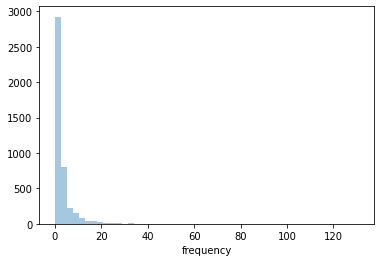

In [ ]:
sns.distplot( lf_data['frequency'] ,kde= False,  bins=50)



(0.0, 30.0)

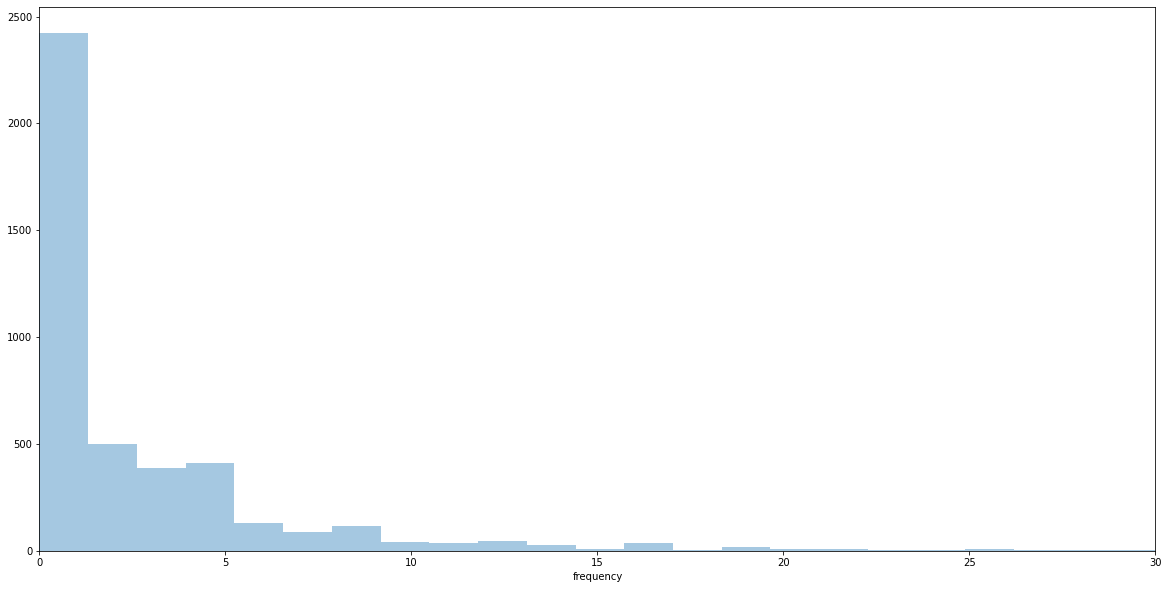

In [ ]:

plt.figure(figsize = (20,10))
sns.distplot( lf_data['frequency'] ,kde= False,  bins=100)

sns.distplot
plt.xlim(0 , 30)


In [ ]:
from lifetimes import BetaGeoFitter

bgf= BetaGeoFitter(penalizer_coef = 0.0 )

bgf.fit( lf_data['frequency'] , lf_data['recency']  , lf_data['T'] )

bgf



<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>

In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


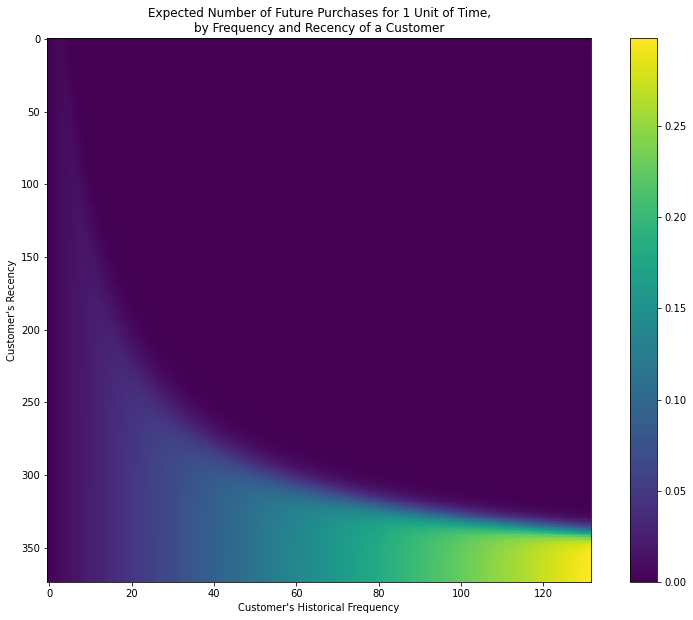

In [ ]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig = plt.figure(figsize = (14 , 10))
plot_frequency_recency_matrix(bgf)


<Figure size 1440x720 with 0 Axes>

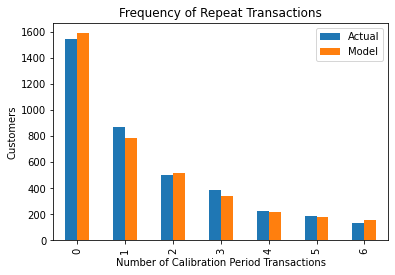

In [ ]:
from lifetimes.plotting import plot_period_transactions

fig = plt.figure(figsize = (20 , 10))

plot_period_transactions(bgf)